![](https://github.com/kalelmartinho/7daysOfCode/blob/master/7daysOfCode.png?raw=true)

---

Por *Kalel Leonardo Martinho*

# #7DaysOfCode - 3: Forecasting 🔎

Criar um modelo de predição com os dados CEAPs

---

Vamos começar configurando nosso ambiente

In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot

import numpy as np
import matplotlib.pyplot as plt


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster, backtesting_forecaster

from sklearn.preprocessing import StandardScaler

# Configuração de warnings
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv('CEAPS_dados_2010_2022.csv', sep=';', index_col=[0], parse_dates=[5])


### Agora vamos adaptar nossos dados para modelos de machine learning

In [2]:
ds = df.copy()
ds = ds.drop(['CNPJ_CPF', 'FORNECEDOR', 'SENADOR', 'DETALHAMENTO'], axis = 1)
ds.rename(columns={'VALOR_REEMBOLSADO': 'vr'}, inplace = True)
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286388 entries, 0 to 286387
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   TIPO_DESPESA  286388 non-null  object        
 1   DATA          286388 non-null  datetime64[ns]
 2   vr            286388 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 8.7+ MB


Decidi por categorizar os anos de eleição e pandemia. Criando duas novas colunas para nosso modelo.

In [3]:
ds['eleicao'] = ds.apply(lambda x: True if (x['DATA'].year == 2010) | (x['DATA'].year == 2014) | (x['DATA'].year == 2018) | (x['DATA'].year == 2022) else False, axis=1)
ds['pandemia'] = ds.apply(lambda x: True if (x['DATA'].year == 2020) | (x['DATA'].year == 2021) else False, axis=1)

Agora vamos adaptar nossos dados categórico em 'TIPO_DESPESA'

In [4]:
ds['TIPO_DESPESA'].unique()

array(['Aluguel de imóveis para escritório político, compreendendo despesas concernentes a eles.',
       'Divulgação da atividade parlamentar',
       'Locomoção, hospedagem, alimentação, combustíveis e lubrificantes',
       'Aquisição de material de consumo para uso no escritório político, inclusive aquisição ou locação de software, despesas postais, aquisição de publicações, locação de móveis e de equipamentos. ',
       'Contratação de consultorias, assessorias, pesquisas, trabalhos técnicos e outros serviços de apoio ao exercício do mandato parlamentar',
       'Passagens aéreas, aquáticas e terrestres nacionais',
       'Serviços de Segurança Privada'], dtype=object)

In [5]:
ohe = OneHotEncoder(sparse=False)
encoded = np.asarray(ds['TIPO_DESPESA']).reshape(-1,1)
despesa = pd.DataFrame(ohe.fit_transform(encoded))
ds = pd.concat([ds, despesa], axis=1)
ds = ds.drop(['TIPO_DESPESA'], axis = 1)

Precisamos também remover uma das colunas recém criadas para não cairmos na [dummy trap](https://www.learndatasci.com/glossary/dummy-variable-trap/)

In [6]:
ds = ds.drop([0], axis = 1)

---

Vamos agora separar os dados de treino e validação

In [7]:
y = ds.vr
X = ds.drop(['vr', 'DATA'], axis = 1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, train_size=0.8, random_state=85)

Agora vamos testar nossos dados em um modelo DummyRegressor

In [8]:
model_d = DummyRegressor()
model_d.fit(X_train, y_train)
dummy_pred = model_d.predict(X_valid)
mean_absolute_error(y_valid, dummy_pred)

1067.7109298910536

Vamos testar os dados em um modelo DecissionTreeRegressor procurando pelo melhor max_leaf_nodes

In [9]:
def get_mae_tr(n_leafs, train_X, val_X, train_y, val_y):
    model_tr = DecisionTreeRegressor(max_leaf_nodes=n_leafs, random_state=85)
    model_tr.fit(train_X, train_y)
    preds_tr = model_tr.predict(val_X)
    mae_tr = mean_absolute_error(val_y, preds_tr)
    return(mae_tr)
                 
for leafs in range(5, 55, 5):
    mae_tr = get_mae_tr(leafs, X_train, X_valid, y_train, y_valid)
    print('Max leaf nodes: %d \t\t Mean Absolute Error: %d' %(leafs, mae_tr))

Max leaf nodes: 5 		 Mean Absolute Error: 951
Max leaf nodes: 10 		 Mean Absolute Error: 934
Max leaf nodes: 15 		 Mean Absolute Error: 931
Max leaf nodes: 20 		 Mean Absolute Error: 929
Max leaf nodes: 25 		 Mean Absolute Error: 929
Max leaf nodes: 30 		 Mean Absolute Error: 929
Max leaf nodes: 35 		 Mean Absolute Error: 929
Max leaf nodes: 40 		 Mean Absolute Error: 929
Max leaf nodes: 45 		 Mean Absolute Error: 929
Max leaf nodes: 50 		 Mean Absolute Error: 929


Vamos testar os dados em um modelo RandomForestRegressor procurando pelo melhor n_estimators

In [10]:
def get_mae_fr(n, train_X, val_X, train_y, val_y):
    model_fr = RandomForestRegressor(n_estimators=n, random_state=85)
    model_fr.fit(train_X, train_y)
    preds_fr = model_fr.predict(val_X)
    mae_fr = mean_absolute_error(val_y, preds_fr)
    return(mae_fr)
                 
for n in range(1, 10, 2):
    mae_fr = get_mae_fr(n, X_train, X_valid, y_train, y_valid)
    print('N_estimators: %d \t\t Mean Absolute Error: %d' %(n, mae_fr))

N_estimators: 1 		 Mean Absolute Error: 929
N_estimators: 3 		 Mean Absolute Error: 928
N_estimators: 5 		 Mean Absolute Error: 929
N_estimators: 7 		 Mean Absolute Error: 929
N_estimators: 9 		 Mean Absolute Error: 929


Agora utilizando RandomForestRegressor vamos fazer um teste de cross-validation com cross_val_score

In [11]:
from sklearn.model_selection import cross_val_score

model_fr = RandomForestRegressor(n_estimators=3, random_state=85)

scores_cv = -1 * cross_val_score(model_fr, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f'Média dos MAE entre os experimentos: {scores_cv.mean()}')
scores_cv

Média dos MAE entre os experimentos: 931.2855776496465


array([ 856.11230614,  816.82612702,  902.68870641,  912.85814422,
       1167.94260446])

Vamos agora testar um modelo de Gradient Boosting com XGBoost

In [12]:
from xgboost import XGBRegressor

model_gb = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping_rounds=5)
model_gb.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
pred_gb = model_gb.predict(X_valid)
mae_gb = mean_absolute_error(y_valid, pred_gb)
mae_gb

929.4862861821964

---

In [13]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
plt.style.use('fivethirtyeight')

In [14]:

#data = ds.drop([1, 2, 3, 4, 5, 6], axis = 1)

#sec = pd.to_timedelta(data.groupby('date').cumcount().add(1).mul(1), unit='s')
#data['date'] = data['date'] + sec
data = ds.copy()
data = data.rename(columns={'DATA': 'date'})
data = data.set_index('date')
data = data.resample(rule='M', closed='left', label ='right')\
       .agg({'vr': 'sum', 'eleicao': 'max', 'pandemia': 'max', 1: 'sum', 2: 'sum', 3: 'sum', 4: 'sum', 5: 'sum', 6: 'sum'})
    
#data = data.resample(rule='M', closed='left', label ='right').agg({'vr': 'sum', 'eleicao': 'max', 'pandemia': 'max'})
    
    
#data = data.asfreq('MS')
#data = data.sort_index()

In [15]:
data.head()

,vr,eleicao,pandemia,1,2,3,4,5,6
date,,,,,,,,,
2010-01-31,797009.90,True,False,165.0,76.0,57.0,754.0,0.0,0.0
2010-02-28,836040.72,True,False,178.0,68.0,62.0,994.0,0.0,0.0
2010-03-31,1077340.24,True,False,217.0,83.0,85.0,1249.0,0.0,0.0
2010-04-30,900934.90,True,False,188.0,82.0,13.0,1101.0,0.0,0.0
2010-05-31,897544.91,True,False,193.0,70.0,0.0,1265.0,0.0,0.0


Train dates : 2010-01-31 00:00:00 --- 2019-10-31 00:00:00  (n=118)
Test dates  : 2019-11-30 00:00:00 --- 2022-04-30 00:00:00  (n=30)


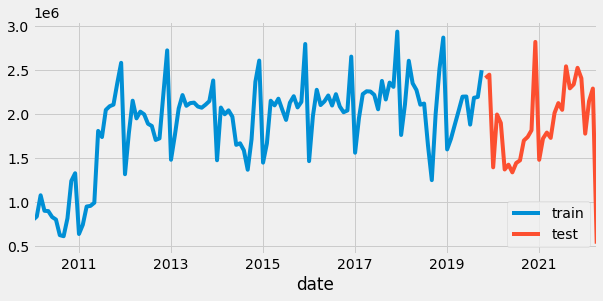

In [16]:
steps = 30
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['vr'].plot(ax=ax, label='train')
data_test['vr'].plot(ax=ax, label='test')
ax.legend();

In [17]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(n_estimators=3, random_state=85),
                lags = 6
                )

forecaster.fit(y=data_train['vr'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(n_estimators=3, random_state=85) 
Lags: [1 2 3 4 5 6] 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2010-01-31 00:00:00'), Timestamp('2019-10-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: M 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 3, 'n_jobs': None, 'oob_score': False, 'random_state': 85, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-04-27 12:00:05 
Last fit date: 2022-04-27 12:00:05 
Skforecast version: 0.4.3 

In [18]:
steps = 30
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2019-11-30    2.331419e+06
2019-12-31    2.741133e+06
2020-01-31    1.502265e+06
2020-02-29    1.987876e+06
2020-03-31    1.776708e+06
Freq: M, Name: pred, dtype: float64

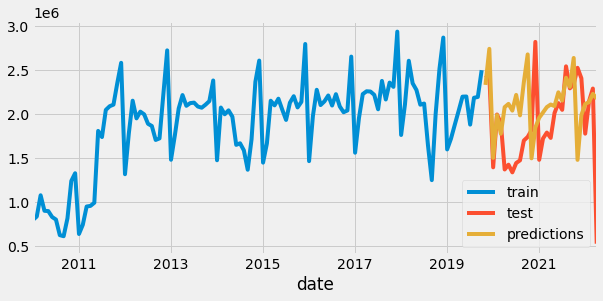

In [19]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train['vr'].plot(ax=ax, label='train')
data_test['vr'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [20]:
error_mse = mean_squared_error(
                y_true = data_test['vr'],
                y_pred = predictions
            )

---

In [21]:
def custom_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    lags = y[-1:-11:-1]
    mean = np.mean(y[-20:])
    predictors = np.hstack([lags, mean])
    
    return predictors

forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor(random_state=85),
                fun_predictors = custom_predictors,
                window_size    = 20
             )

# Regressor's hyperparameters
param_grid = {'n_estimators': [3],
              'max_depth': [3, 5, 100]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train['vr'],
                        param_grid  = param_grid,
                        steps       = steps,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False
               )

Number of models compared: 3


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  5.75it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: custom predictors 
  Parameters: {'max_depth': 3, 'n_estimators': 3}
  Backtesting metric: 126704899084.08171



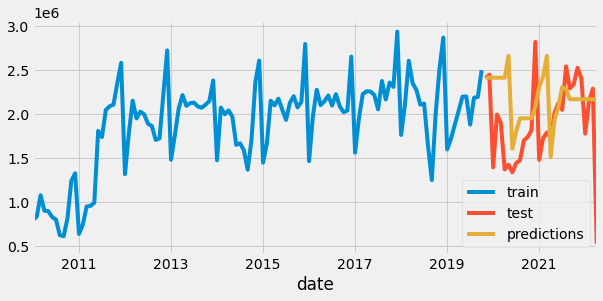

In [22]:
predictions = forecaster.predict(steps=steps)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['vr'].plot(ax=ax, label='train')
data_test['vr'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

---

In [23]:
steps = 30
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 2010-01-31 00:00:00 --- 2019-10-31 00:00:00  (n=118)
Test dates  : 2019-11-30 00:00:00 --- 2022-04-30 00:00:00  (n=30)


In [24]:
# Criar e treinar o forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags = 15
             )

forecaster.fit(y=data_train['vr'])

# Prediction intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    interval = [1, 99],
                    n_boot   = 500
              )

predictions.head(5)

,pred,lower_bound,upper_bound
2019-11-30,2.443632e+06,1.828889e+06,2.902650e+06
2019-12-31,2.567771e+06,1.913677e+06,3.091474e+06
2020-01-31,1.615843e+06,1.003838e+06,2.162601e+06
2020-02-29,1.957218e+06,1.167547e+06,2.547840e+06
2020-03-31,2.205118e+06,1.483887e+06,2.743993e+06


Test error (mse): 237646252708.98322


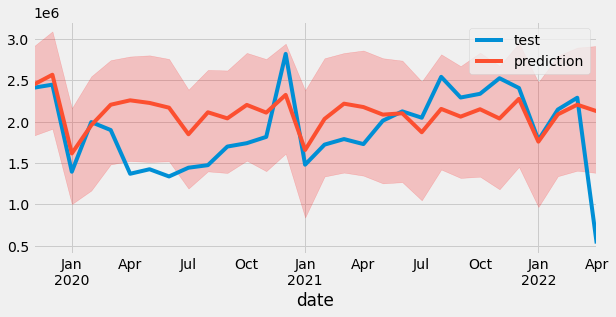

In [25]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['vr'],
                y_pred = predictions.iloc[:, 0]
            )

print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_test['vr'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='prediction')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();

Information of backtesting process
----------------------------------
Number of observations used for initial training: 76
Number of observations used for backtesting: 72
    Number of folds: 3
    Number of steps per fold: 30
    Last fold only includes 12 observations.

Data partition in fold: 0
    Training:   2010-01-31 00:00:00 -- 2016-04-30 00:00:00
    Validation: 2016-05-31 00:00:00 -- 2018-10-31 00:00:00
Data partition in fold: 1
    Training:   2010-01-31 00:00:00 -- 2018-10-31 00:00:00
    Validation: 2018-11-30 00:00:00 -- 2021-04-30 00:00:00
Data partition in fold: 2
    Training:   2010-01-31 00:00:00 -- 2021-04-30 00:00:00
    Validation: 2021-05-31 00:00:00 -- 2022-04-30 00:00:00



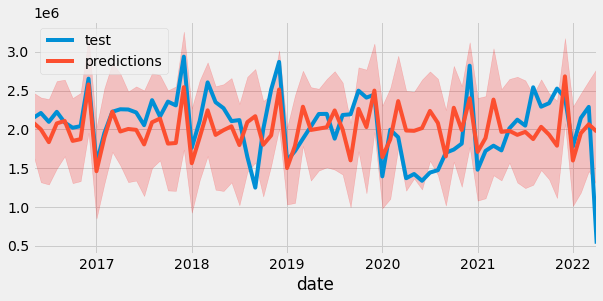

In [26]:
n_backtesting = 24*3
steps = 30
forecaster = ForecasterAutoreg(
                regressor = LinearRegression(),
                lags      = 15
             )

metric, predictions = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data['vr'],
                            initial_train_size = len(data) - n_backtesting,
                            fixed_train_size   = False,
                            steps              = steps,
                            metric             = 'mean_squared_error',
                            refit              = True,
                            interval           = [1, 99],
                            n_boot             = 100,
                            verbose            = True
                      )


fig, ax = plt.subplots(figsize=(9, 4))
data.loc[predictions.index, 'vr'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();

In [ ]:
inside_interval = np.where(
                     (data.loc[predictions.index, 'vr'] >= predictions['lower_bound']) & \
                     (data.loc[predictions.index, 'vr'] <= predictions['upper_bound']),
                     True,
                     False
                   )

coverage = inside_interval.mean()
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

Predicted interval coverage: 90.28 %


---
